# **Classificar comentários da internet como tóxicos ou impróprios com uso de RNNs**

In [40]:
#Garantir que está usando a versão mais recente de Keras
! pip install keras --upgrade

# **Recurrent Neural Networks (RNN) applied to Natural Language Processing (NLP)**

- Neste projeto, é utilizado um vocabulário (conjunto de palavras em inglês) previamente convertido em vetores de palavras.
- Estes dados são combinados a uma base de dados contendo comentários de internet previamente rotulados em 6 rótulos de toxicidade, os quais não são mutuamente exclusivos. O comentário pode estar classificado (Resposta = 1) ou não estar classificado (Resposta = 0) naquele rótulo, de modo que temos 6 variáveis-respostas independentes (o comentário pode receber nenhum rótulo ou até 6 rótulos).

Podemos aplicar as redes neurais recorrentes (RNNs) a sequências de "word embeddings".
- Em particular, **utilizaremos o LSTM como unidade recursiva**.

# **Roteiro para construção de modelos em Keras**

1) Carregar os dados e convertê-los a um formato adequado para a construção do modelo. **As funções do Pandas são necessárias para converter bases gravadas como CSV ou arquivo Excel em objetos do tipo dataframe**, independente se os dados forem previamente carregados no Google Drive, se foram carregados diretamente no ambiente do Google Colab, ou se foram carregados offline usando uma IDE como o Anaconda.

2) Criar o modelo: aqui, forneceremos ao Keras a estrutura do modelo, por exemplo, tipos e configurações das camadas da rede neural, bem como a sequência das camadas e operações.

3) Treinar o modelo com os dados e avaliar seus resultados.

# **Fazer upload de arquivos a partir de sistema de arquivos local**

<code>files.upload</code> é um comando que retorna um dicionário Python com os arquivos incluídos no upload.
O dicionário é indexado com o nome do arquivo e os valores são os dados enviados por upload.

CONFIGURAR Ambiente do COLAB:
No menu superior, clique sobre a seta ao lado das barras RAM e Disco. No dropdown mostrado, selecione 
**"Ver recursos"**.

No novo menu, utilize a barra de rolagem até chegar ao extremo inferior, e selecione a opção **"Alterar o tipo de ambiente de execução"**.

Por fim, em **"Acelerador de hardware"**, selecione **"GPU"**.

Vamos carregar os arquivos com textos a serem classificados via CNN. Eles estão disponíveis nos links abaixo:

Download the data:
https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

Download the word vectors:
http://nlp.stanford.edu/data/glove.6B.zip


Os arquivos glove.6B possuem vetores de palavras já definidos. Como os arquivos são muito pesados, é melhor carregá-los primeiramente no Google Drive para posteriormente trazê-los ao ambiente do Colab (carregar diretamente no Colab levará tempo excessivo).

# **Google Drive**

É possível acessar os arquivos no Drive de várias maneiras. Por exemplo:
- Montar o Google Drive na máquina virtual do ambiente de execução
- Usar um wrapper ao redor da API, <a href="https://pythonhosted.org/PyDrive/">como o PyDrive</a>
- Usar a <a href="https://developers.google.com/drive/v3/web/about-sdk">API REST nativa</a>



Veja abaixo exemplos de cada um eles.

# **Montar o Google Drive localmente - Autorizar conexão do Google Colab aos arquivos do Google Drive**

O exemplo abaixo mostra como montar o Google Drive no seu ambiente de execução usando um código de autorização, além de como gravar e ler arquivos nele. Depois de executado, você verá o novo arquivo &#40;<code>foo.txt</code>&#41; no <a href="https://drive.google.com/">https://drive.google.com/</a>.

Isto permite somente ler, gravar e mover arquivos. Para modificar de maneira programática as configurações de compartilhamento ou outros metadados, use uma das opções abaixo.

<strong>Observação:</strong> ao usar o botão "Montar Drive" no navegador de arquivos, não é necessário usar nenhum código de autenticação para notebooks que tenham sido editados somente pelo usuário atual.

In [1]:
#Esta célula é utilizada para conectar à conta do Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


No menu à esquerda, clique sobre o ícone da pasta ("**Arquivos**"), e localize dentro da nova pasta "drive" a pasta do Google Drive contendo os arquivos desejados (clique na seta para expandir os dropdowns). 

Clique sobre a elipse (3 pontos à direita) do arquivo desejado e selecione a opção "**Copiar caminho**" para copiar os endereços de cada um dos arquivos que serão analisados.

Note que o caminho será diferente para cada usuário do Google Drive.

Endereços:

glove.6B.100d.txt: "/content/drive/MyDrive/Coisas úteis separadas para a Paula/Deep Learning - Advanced NLP and RNNs/Lesson 1 - convolutional neural networks/glove.6B.100d.txt"

sample_submission.csv: "/content/drive/MyDrive/Coisas úteis separadas para a Paula/Deep Learning - Advanced NLP and RNNs/Lesson 1 - convolutional neural networks/sample_submission.csv"

test.csv: "/content/drive/MyDrive/Coisas úteis separadas para a Paula/Deep Learning - Advanced NLP and RNNs/Lesson 1 - convolutional neural networks/test.csv"

test_labels.csv: "/content/drive/MyDrive/Coisas úteis separadas para a Paula/Deep Learning - Advanced NLP and RNNs/Lesson 1 - convolutional neural networks/test_labels.csv"

train.csv: "/content/drive/MyDrive/Coisas úteis separadas para a Paula/Deep Learning - Advanced NLP and RNNs/Lesson 1 - convolutional neural networks/train.csv"

# **Importar bibliotecas para análise**

In [2]:
# https://deeplearningcourses.com/c/deep-learning-advanced-nlp
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras import optimizers
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

import keras.backend as K
#if len(K.tensorflow_backend._get_available_gpus()) > 0:
#  from keras.layers import CuDNNLSTM as LSTM
#  from keras.layers import CuDNNGRU as GRU

As bibliotecas "os" e "sys" possibilitam ler e fundir (merge) arquivos, como será visto adiante.

**Tokenizer**: transformar uma sentença (uma grande string contendo palavras e pontuação) em uma lista de strings, na qual cada elemento da lista é chamado de token.

Tokenização é um aspecto chave e mandatório do processamento de textos. Os tokens são os blocos de construção do processamento de linguagem natural, utilizados tanto em métodos tradicionais quanto nos mais modernos algoritmos de deep learning.

A tokenização consiste em separar um trecho de texto em unidades menores (tokens), as quais podem ser palavras, caracteres, ou subpalavras. A forma mais comum de formar tokens é a separação por meio da identificação de espaços em branco que demarcam a separação entre as palavras.

Assim, o token geralmente será uma palavra, mas pode ser pontuação, apóstrofe, parte de uma contração, etc, dependendo da estratégia de tokenização aplicada. Portanto, a tokenização pode ser vista como uma estratégia de split de strings.

**pad_sequences**: nós precisamos deste comando porque desejamos que todas as nossas sequências apresentem o mesmo comprimento. Porém, quando carregamos a sequência no ambiente, elas apresentam diferentes comprimentos.

Assim, nós adicionamos o padding para obter uma saída "reta".

# **Configurações das redes neurais e do processamento de texto**

In [3]:
# some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 5

**MAX_SEQUENCE_LENGTH**: definimos em 100 por se tratarem de comentários de internet. Este parâmetro pode ser modificado: por exemplo, após carregar todos os dados, define-se este parâmetro como sendo igual ao maior comprimento presente. Outra estratégia é verificar o histograma dos comprimentos de comentários para averiguar se o parâmetro escolhido faz sentido.

**MAX_VOCAB_SIZE: tamanho do vocabulário de aprendizagem** (total de palavras do vocabulário). Se houver mais que MAX_VOCAB_SIZE = 20000, o vocabulário será truncado em 20.000 palavras. Experimentos mostraram que um falante de inglês nativo conhece, em média, cerca de 20000 palavras. Embora estes resultados sejam controversos e provavelmente superestimados, este é um valor popularmente adotado para este parâmetro.

**EMBEDDING_DIM**: comprimento de cada vetor de palavras (word vector). Você não pode escolher qualquer comprimento quando trabalhando com modelos pré-treinados. Isto porque os *modelos pré-treinados costumam vir com determinados valores de comprimento de vetor de palavras fixados*. Aqui, usaremos vetores de comprimento 50 ou 100, mas comprimentos iguais a 200 e 300 também estão disponíveis nos arquivos.

# **Vamos criar um dicionário vazio, chamado word2vec** 
Este dicionário armazenará os dados já pré-configurados, i.e., palavras que já foram convertidas em vetores numéricos, e que estão disponíveis nas bases glove.6B.

- O comprimento dos vetores de palavras será o definido e armazenado em EMBEDDING_DIM.
- O dicionário possui como estrutura: a palavra como a chave (key); e o vetor de palavras (word vector) como o valor correspondente.
- A nomenclatura word2vec vem de "word pointing to vector".
- Os arquivos glove.6B consistem em txt contendo a cada linha uma palavra seguida dos valores das componentes dos vetores, separados por espaços em branco.
- Assim, nós: 1) carregamos uma linha; 2) dividimos (split) as linhas em tokens; 3) tomamos o primeiro token como sendo a palavra; 4) tomamos os demais tokens como o vetor; 5) convertemos o vetor em um NumPy array; 6) e, por fim, salvamos cada array no nosso dicionário.

**ATENÇÃO**

O endereço dos arquivos deve ser inserido com o número correto de espaçamentos. A inclusão de espaços em branco a mais no começo e no fim resultará em erro de processamento.

In [4]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
#dicionário em branco, a ser povoado

with open(os.path.join('/content/drive/MyDrive/Coisas úteis separadas para a Paula/Deep Learning - Advanced NLP and RNNs/Lesson 1 - convolutional neural networks/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


Não imprima o dicionário word2vec! Devido ao seu tamanho elevado, sobrecarregará a visualização do notebook.

Note que ainda não começamos o treinamento das CNNs. O que fizemos aqui foi abrir uma série de arquivos de texto previamente carregados no Google Drive (arquivos contendo dados pré-treinados de palavras convertidas em vetores numéricos). Após abri-los com o comando with open, manipulamos as strings para que os dados povoassem um dicionário vazio.

Caso estivesse usando um ambiente offline, e não o Google Colab, o seguinte código deveria ser utilizado:

```
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('../large_files/glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))
```



Note que o trecho `glove.6B.%sd.txt' % EMBEDDING_DIM`

faz com que todos os arquivos com o número %s = EMBEDDING_DIM sejam lidos.


# **Vamos carregar os dados de treinamento, formados pelos comentários de internet a serem classificados em "toxicidade"**

In [5]:
# prepare text samples and their labels
print('Loading in comments...')

train = pd.read_csv("/content/drive/MyDrive/Coisas úteis separadas para a Paula/Deep Learning - Advanced NLP and RNNs/Lesson 1 - convolutional neural networks/train.csv")
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values

Loading in comments...


Note que, como ocorre para qualquer CSV ou arquivo Excel, seja ele carregado no ambiente Python offline, no Google Drive, ou diretamente no Google Colab, **precisamos invocar as funções do Pandas read_csv ou read_excel para converter o arquivo em um objeto do tipo dataframe**.


Vamos verificar o aspecto geral do dataframe de treinamento:

In [12]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [13]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


A etapa seguinte consiste em extrair o que são de fato os comentários.
- Nesta base de dados, os comentários estão dispostos na forma: coluna; comentário; texto.
- Na linha a seguir, note que não foi utilizado o dropna, que remove as linhas contendo missing values. Foi utilizado o comando **"fillna"**, o qual confere o valor "DUMMY_VALUE" às entradas sem valores:
```
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
```
- Note ainda que o comando **.values** faz com que o NumPy array "sentences" armazene apenas os valores do campo "comment_text" dos dados de treino (já com o preenchimento dos missing values).
- A lista "possible_labels" define como os comentários poderão ser rotulados. Note que as classificações não são mutuamente exclusivas: um comentário pode ser classificado em mais de um rótulo, de modo que cada um deles é uma resposta binária **(o comentário pertence = 1; ou não pertence = 0 àquela classe)** independente.
- Na realidade, esta lista não apresenta nomes que serão fornecidos ao dataframe de treino. Ela apenas discrimina quais dados do dataframe serão utilizados como targets.
- Esta lista é passada como argumento da linha a seguir. Nela, **o comando .values faz com que o dataframe "target" armazene os valores das colunas dos dados de treinamento, desde que estas colunas estejam entre as discriminadas na lista**.

# **Aplicar o método keras.tokenizer para conversão das sentenças em números inteiros**

Esta é mais uma etapa de pré-processamento textual. Note que, até aqui, ainda temos uma lista que lembra uma serra, já que cada sentença ainda apresenta um comprimento diferente.
- Logicamente, a lista ainda é constituída por strings, o que não é processável pelas redes neurais (as redes neurais exigem que as strings sejam convertidas em valores numéricos).
- As strings ainda contêm os comentários completos, ou seja, ainda não foram tokenizadas.
- Devemos aplicar o **método tokenizer da biblioteca keras** para resolver estes problema: o **keras.tokenizer** converte as sentenças em listas de tokens e, a seguir, converte estas listas em números inteiros.
- Estes números inteiros serão usados para indexar o **word embedding** (a matriz contendo os vetores das palavras, na qual cada linha da matriz corresponde ao vetor numérico de uma palavra).

In [6]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

# **Caracterização das sequências de texto obtidas e convertidas em inteiros**

Vamos caracterizar os comentários, agora que foram tokenizados e convertidos em números inteiros

In [7]:
print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sequence length:", s[len(s) // 2])

print("max word index:", max(max(seq) for seq in sequences if len(seq) > 0))

max sequence length: 1400
min sequence length: 0
median sequence length: 35
max word index: 19999


Note que aqui as sequências são, na realidade, os comentários, os quais podem conter mais de uma sentença. Porém, para os propósitos desta análise em particular, é mais simples chamar a string completa do comentário de sentença.

# **Associar cada palavra a uma linha (vetor de palavras) do word embedding**

Agora que as sentenças foram convertidas em números inteiros, surge a pergunta sobre a qual palavra cada número inteiro corresponde.
- Além disso, desejamos saber qual linha do word embedding pertence a cada palavra.
- Lembrando o que é o word embedding: **word embedding é a matriz dos vetores das palavras. Cada linha do word embedding representa o vetor numérico associado a cada palavra**. 
- Indexar aqui significa encontrar o índice do vetor (ou seja a linha do word embedding) que descreve cada uma das palavras tokenizadas.

Para isso, precisamos de um **mapeamento palavra-para-índice** (word to index mapping).
- Neste mapa, a chave (key) será a palavra, e o índice será o valor correspondente.
- **O keras.tokenizer mantém esta informação de mapeamento em um atributo chamado word_index**.

In [8]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 210337 unique tokens.


Note que o mesmo atributo é utilizado para nos informar **quantas palavras foram encontradas no dataset: este valor será igual ao tamanho (length) do dicionário obtido**.

# **Limitar comprimento das sequências de texto com o método pad_sequences**

Neste momento, ainda temos um problema com nossos dados: os arrays continuam com tamanhos diferentes, formando um aspecto de serra.

- Para resolver este problema, a próxima etapa de pré-processamento será aplicar o **método pad_sequences, com comprimento máximo definido previamente na variável MAX_SEQUENCE_LENGTH**.

In [9]:
# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (159571, 100)


Esta etapa é particularmente importante porque a biblioteca **Keras trabalha com sequências de dimensões constantes**.
- O formato do tensor de dados representa a dimensão da matriz (N x T) obtida. Limitamos a 100 o máximo comprimento da sequência de textos.
- N = contagem de elementos, que foi anteriormente observada na linha **count** do dataframe gerado como** train.describe()**;
- T será o máximo comprimento permitido para o vetor de palavras (máximo possível de colunas), definido como **MAX_SEQUENCE_LENGTH = 100**.

Note que, para que todas as sequências tenham o mesmo comprimento, **caso o vetor tenha um comprimento menor que MAX_SEQUENCE_LENGTH, o método pad_sequences adicionará vários números zero ao fim dele** até que ele atinja o comprimento máximo.

Uma questão que surge é como saber se o vetor ao qual foram adicionados os números zero não passou a ser igual a um outro vetor de palavras previamente definido no nosso vocabulário.
- Esta é uma questão válida, já que, ao construir o dicionário que correlaciona as palavras aos índices, nós utilizamos o zero para representar uma das palavras.
- Porém, **neste caso em particular, Keras inicia a indexação pelo número 1, e apenas utiliza o zero como um valor especial reservado para a operação de padding**.
- Desde que você **permaneça no ecossistema Keras durante as etapas de pré-processamento de texto**, a adição dos números zero não será um problema.

# **Pré-carregar a matriz de incorporação ("embedding matrix") que será utilizada pela rede neural**

No começo deste notebook, carregamos vetores de palavras previamente definidos, contidos no arquivo glove.

- A primeira coisa a fazer agora é verificar o número de palavras que será realmente utilizado como vocabulário da rede neural.

Este valor é simplesmente o mínimo entre MAX_VOCAB_SIZE = 20000, e o **comprimento (total de palavras) do dicionário** palavra-para-índice ("*word to index dictionary*") **somado a 1**.

Explicação:
- Lembre-se que definimos nos parâmetros de configuração inicial:
```
MAX_VOCAB_SIZE = 20000
```

- Entretanto, o número de palavras no dataset pode ser menor que 20.000. Neste caso, nós não queremos que sejam criados 20.000 vetores de palavras, mas sim o **menor número possível de vetores** (ou seja, armazenaremos menos que 20000 palavras).

- Por sua vez, o número de palavras pode ser superior a 20000. Nesta situação, **desejamos truncar os dados (o vocabulário) para que reste apenas MAX_VOCAB_SIZE = 20000 vetores**.

In [10]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)

Filling pre-trained embeddings...


O trecho acima:

1) Verifica o total de vetores de palavras presente no vocabulário (o comprimento/dimensão do dicionário);

2) Compara este valor com MAX_VOCAB_SIZE.
- Se o tamanho do vocabulário for menor que MAX_VOCAB_SIZE, então MAX_VOCAB_SIZE é igualado ao tamanho do dicionário + 1 para que possamos trabalhar com o menor número possível de vetores de palavras (i.e., com menos palavras);
- Se a dimensão for maior que MAX_VOCAB_SIZE, truncamos o vocabulário de modo que ele terá apenas MAX_VOCAB_SIZE = 20000 palavras.

Note que **precisamos somar 1** em

```
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
```
**Porque, como visto, a biblioteca Keras inicia a indexação dos vetores de palavras em 1**, reservando o valor zero para as operações de padding.

Assim, se tivermos 20000 palavras, o índice da última palavra será efetivamente 20000, e não 19999 (índice esperado se a numeração começasse em zero, como comumente ocorre com as listas em Python).

Assim, caso deseje utilizar o índice para indexar um array, é necessário acrescentar um elemento. Isso porque, em Python, a numeração dos elementos dos arrays, assim como das listas, começa em zero.


Outra questão que pode surgir é: uma vez que tomamos o mínimo entre 20000 e o tamanho do vocabulário, o que ocorrerá se houver índices no array de dados maiores que 20000?

De fato, caso tente indexar um array por um número maior ou igual ao seu comprimento, o resultado será uma exceção ("*exception error*").

Felizmente, esta questão já foi resolvida anteriormente durante a criação do tokenizer:
```
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
```
Como utilizamos MAX_VOCAB_SIZE como um dos argumentos do método Tokenizer, **Keras já definiu que estes índices, caso existam, estarão fora dos tolkens do vocabulário**.

- OBS: comumente encontramos estas situações que foram assinaladas como fora dos tolkens referenciadas pela abreviatura **OOV** ("*out of vocabulary*").
- Outra abreviação comumente encontrada em comentários de códigos é **UNK, referente a unknown**.

# **Criação da matriz embedding**

A última etapa do pré-processamento do texto consiste em criar uma matriz V x D de zeros, que será o **embedding**. V é simplesmente o número de palavras num_words, o qual já calculamos, e D é a dimensão do embedding, EMBEDDING_DIM.

A seguir, criamos um loop que avalie cada palavra do dicionário palavras-para-índices ("word to index dictionary").

- **Se o índice for menor que o MAX_VOCAB_SIZE** (já corrigido para o caso de haver menos palavras que o definido nos parâmetros), **então ele deverá estar no embedding**.
- Esta etapa consiste, então, em uma tentativa de recuperar o vetor de palavras pré-treinado do dicionário de palavras.
- Lembre-se que os **vetores de palavras pré-configurados vêm de uma fonte (arquivos glove) diferente da fonte dos comentários classificados como tóxicos e utilizados como dados de treinamento** (arquivo train.csv). 
- Como os dados de treinamento é que são utilizados para construir o dicionário, **é possível que determinados vetores de palavras pré-treinados não sejam encontrados no dicionário** (as duas fontes de dados, glove e train, não são necessariamente equivalentes).



In [11]:
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Repare que utilizamos o método **get** em:

```
word2vec.get(word)
```
Caso a chave (key) correspondente a um dos vetores de palavras pré-configurados não seja encontrada no dicionário (ou seja, caso aquela palavra não esteja presente no vocabulário de treinamento), **o método get simplesmente retorna um valor nulo como chave do dicionário, ao invés de gerar uma exceção, como ocorreria ao se tentar indexar um array ou lista**.

- O trecho acima também verifica, na sequência, se o vetor é nulo, em:
```
 if embedding_vector is not None:
```
- Caso o vetor não seja nulo, ele é assinalado à matriz de embedding na localização apropriada.



# **Construção e avaliação da RNN**

As etapas anteriores constituíram o pré-processamento do texto necessário à construção do modelo de redes neurais.

Estas etapas constituem cerca de 90% do código do notebook, e **muitas delas são genéricas e aplicáveis a diversos exemplos de NLP**.

# **Criação da camada de embedding**

A criação da camada de embedding consiste em simplesmente criar um objeto do tipo "**Embedding**".

In [12]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)


print('Building model...')

Building model...


Os dois primeiros argumentos para construção da camada de embedding são o total de palavras "**num_words**" (tamanho do vocabulário); e a dimensão do embedding "EMBEDDING_DIM".

- A seguir, vem o argumento **"weights"**: nós passamos como argumento justamente **a matriz de embedding que construímos nas etapas anteriores**.
- O argumento **"input_length"** informa ao objeto embedding **quão longas nossas sequências serão. Este valor foi fornecido inicialmente em MAX_SEQUENCE_LENGTH**.
- No último argumento ("**trainable**") fornecemos o valor booleano **False pois não desejamos que os pesos sejam atualizados durante o procedimento de treino (estamos utilizando vetores pré-treinados** da base glove.6B).
- Logicamente, é permitido realizar a atualização, modificando-se o parâmetro para True. Porém, isto representará maior custo computacional e, possivelmente, um tempo longo de treinamento.

# **Construção do restante do modelo de redes neurais convolucionais (CNNs)**

Temos aqui um tensor de dados (variável "data") constituídos pelos comentários a serem classificados. É uma matriz N x T contendo os índices das palavras, na qual N é o total de amostras/dados e T é o comprimento da sequência.
- Temos também a variável "target", que representa os rótulos atribuídos a cada sequência. É uma matriz de dimensão N x 6, já que definimos 6 rótulos possíveis.
- Além disso, temos a matriz de embedding, de dimensão V x D, à qual já assinalamos alguns vetores de palavras. V é o tamanho do vocabulário e D é a dimensão do embedding.


Para construção da rede neural em Keras, o primeiro requisito é criar o objeto de input.

- Devemos especificar cada uma das dimensões, exceto o tamanho da amostra, o qual já está implícito.
- Como visto, o input usará como argumento um tensor de dados de dimensão N x T, onde N = contagem de elementos (tamanho de amostra, implícito), e T = máximo comprimento permitido para o vetor de palavras = **MAX_SEQUENCE_LENGTH = 100**.
- Assim, precisamos apenas fornecer T = MAX_SEQUENCE_LENGTH como argumento de criação do objeto de input.

A seguir, utilizamos este input como argumento da camada de embedding que criamos a pouco.

In [13]:
# create an LSTM network with a single LSTM
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
# x = LSTM(15, return_sequences=True)(x)
x = Bidirectional(LSTM(15, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
output = Dense(len(possible_labels), activation="sigmoid")(x)

Repare no trecho:
```
x = embedding_layer(input_)
```
Aqui está sendo utilizado o API funcional Keras ("Keras functional API") para passar o input como argumento da camada de embedding.
- Isto torna a sintaxe ligeiramente diferente da encontrada em outros códigos Keras que usam o modelo sequencial.



# **Unidade recursiva: LSTM**

- Após passar pela camada de embedding (assim como ocorre com as CNNs), os inputs têm de passar pela unidade recursiva.

- Aqui, especificamos a unidade recursiva como LSTM.
- Repare que definimos `return_sequences = True`, de modo que o sistema retorna todos os estados como valores de saída (e não apenas o último estado, como ocorre quando este parâmetro está em seu valor padrão, False).

# **Camada de agrupamento ("Pooling layer")**

https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/

A explicação a seguir refere-se ao caso mais geral das redes neurais convolucionais com 2 dimensões, aplicadas ao processamento de imagens. Como o caso bidimensional é uma extensão do unidimensional, as mesmas considerações são válidas para o processamento de textos por NLP.

As camadas convolucionais em uma rede neural convolucional aplicam sistematicamente os filtros aprendidos às imagens de input de modo a criar mapas de características ("**feature maps**") que resumem a presença daquelas características da imagem de entrada.

As camadas convolucionais se mostram bastante eficientes, e o empilhamento ("stacking") de camadas convolucionais em modelos deep learning permitem que as camadas mais próximas ao input aprendam características de baixo nível ("low-level features"), tais como linhas. Enquanto isso, as camadas mais profundas do modelo aprendem características de ordem mais elevada e mais abstratas, tais como a forma ou objetos específicos.

**Uma limitação do mapa de características das camadas convolucionais é que eles gravam a posição precisa das características de input**. Isto significa que pequenos deslocamentos na posição daquela característica na imagem de input resultarão em um mapa de características diferente. Isto pode ocorrer mesmo com modificações mínimas da imagem, tais como corte, rotação, deslocamento ("shifting"), ou espelhamento da imagem.

Uma metodologia comumente empregada para solucionar este problema no processamento de sinais é chamada redução de amostragem ("down sampling"). Nesta estratégia, **uma versão de resolução mais baixa do sinal de entrada é criada, e tal versão contém os maiores ou mais importantes elementos estruturais, mas não os detalhes finos que podem não ser tão úteis na tarefa de classificação**.

O "down sampling" pode ser obtido com as camadas convolucionais por meio da alteração do caminho de convolução ao qual se submete a imagem. **Uma abordagem comum e mais robusta é a utilização de uma camada de agrupamento ("pooling layer")**.

A camada de agrupamento é uma nova camada adicionada após a camada convolucional. Mais especificamente, **uma não-linearidade (e.g. ReLU) é aplicada aos mapas de características obtidos como saída da camada convolucional, e estes novos mapas são utilizados como inputs da camada de agrupamento**. Assim, a sequência de camadas e operações do modelo segue o esquema:

- Imagem de input;
- Camada Convolucional;
- Não-linearidade;
- Camada de agrupamento.

**A adição da camada de agrupamento após a camada convolucional é um padrão comumente empregado para ordenamento de camadas em uma rede neural convolucional**, e pode ser repetido uma ou mais vezes em um modelo.

A camada de agrupamento opera separadamente sobre cada mapa de características de modo a criar um novo conjunto com o mesmo número de mapas de características agrupadas.

O agrupamento envolve a seleção de uma operação de agrupamento, de forma muito semelhante a um filtro aplicado a mapas de características. As dimensões da operação ou filtro de agrupamento são menores que o tamanho do mapa de características. Quase sempre se aplica 2x2 pixels com um caminho de 2 pixels.

**Isto significa que a camada de agrupamento sempre reduz a dimensão de um mapa de características por um fator igual a 2**. 

**Assim, cada dimensão é reduzida pela metade**, reduzindo o total de pixels (imagem bidimensional) ou os valores do mapa de características a 1/4 do seu tamanho original. Por exemplo, uma camada de agrupamento aplicada a um mapa de características 6x6 (36 pixels) resultará em um mapa de características agrupado (saída) de dimensões 3x3 (9 pixels).

**A operação de agrupamento não é aprendida, mas sim especificada**. Duas funções comumente empregadas para o agrupamento são:

- **"Average Pooling"**: calcula o valor médio para cada fragmento ("patch") do mapa de características.
- **"Maximum Pooling"**: calcula o valor máximo para cada fragmento ("patch") do mapa de características.

O resultado da utilização de uma camada de agrupamento e da criação de amostras reduzidas ou agrupadas dos mapas de características é a **obtenção de uma versão resumida das características a serem detectadas no input**.

Esta versão resumida é útil porque **pequenas mudanças de posição de uma determinada característica na entrada (detectada pela camada convolucional) resultarão em um mapa de características agrupadas ("pooled") com a característica na mesma localização**. 

Esta capacidade fornecida pela "pooling layer" é chamada de **invariância do modelo à translação local**.

Como temos uma única operação de Pooling, esta é **a  última operação de "Maximum Pooling", chamada de Global, e não possui parâmetros de entrada**:

```
x = GlobalMaxPooling1D()(x)
```
**Global Maximum Pooling**: a utilização desta operação indica que temos uma série temporal, mas não nos importamos com o quão longa esta série é. **Apenas tomamos o maior valor da série temporal em cada dimensão**.

- Repare que os inputs são matrizes de dimensões T x M, onde T é o comprimento da sequência e M é o total de propriedades ("features"). Após aplicarmos o Global Maximum Pooling, a saída será de comprimento M.

```
T x M --> GlobalMaxPooling --> M
```
- Esta operação pode ser entendida como **a seleção de qual ponto do intervalo de tempo foi mais importante para o cálculo da saída**.
- Assim, nós percorremos toda a série temporal e, com isso, descobrimos quando ocorreu a característica mais importante.

#### **Note que a operação de Pooling tem a função de encontrar qual o maior dentre todos os valores de saída.** 

Caso desejássemos apenas o último resultado, bastaria manter `return_sequences = False` e não realizar nenhum Pooling.


# **Camadas densas ("dense layers")**

Para completar o modelo, submetemos a saída da última camada de pooling a um par de camadas densas (assim como em redes neurais artificiais simples). Na segunda delas, modificamos a função de ativação para a sigmoide, possibilitando a captura de outros aspectos de não-linearidade.

In [ ]:
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

O motivo de desejarmos utilizar aqui a função sigmoide é que **estamos realizando 6 classificações binárias, uma para cada um dos rótulos de toxicidade propostos**.
- Lembre-se que cada comentário pode ter de 1 a 6 rótulos, ou mesmo nenhum rótulo (situação na qual a resposta é igual a zero para todas as 6 respostas).

Com esta etapa, concluímos a construção do modelo, **sendo a camada de saída do modelo assinalada à variável "output" em**:

```
output = Dense(len(possible_labels), activation='sigmoid')(x)
```
- Repare que a saída do modelo, "output", leva um argumento anterior à última função de ativação: a quantidade de variáveis de saída. **Como temos uma resposta correspondente a cada rótulo, o primeiro argumento é igual ao comprimento (total de elementos) da lista que armazena os rótulos possíveis**.

Por fim, vale destacar que **cada uma das operações de convolução, Pooling, ou Dense corresponde a uma camada da rede neural construída**.

# **Criação de um objeto do modelo ("model object")**

Agora que concluímos a construção do modelo, podemos assinalar ele a um objeto que armazenará as suas principais informações.

- **A função construtora ("constructor") deste objeto utiliza como primeiro argumento o input, e a saída ("output") como segundo argumento**.

In [ ]:
model = Model(input_, output)

Note que o objeto que armazena o modelo foi denominado "model".

# **Compilar o modelo para treinamento**

Neste exemplo, utilizamos a "binary_crossentropy" como função de perda ("loss function"), e não a "categorical cross entropy".

- Em "optimizer", utilizamos um otimizador adaptativo. As outras opções disponíveis podem ser utilizadas aqui.

- Desejamos saber a precisão do modelo enquanto o treinamos. Para isso, passamos "accuracy" como parâmetro de compilamento do modelo.


In [14]:
model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  #optimizer=Adam(lr=0.01),
  metrics=['accuracy'],
)

# **Treinar o modelo**

- Utilizamos o método **.fit** para treinar o modelo.
- **O modelo treinado ficará armazenado no objeto r** definido a seguir.

In [15]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Epoch 1/5
998/998 [==============================] - 51s 43ms/step - loss: 0.1032 - accuracy: 0.9144 - val_loss: 0.0657 - val_accuracy: 0.9941
Epoch 2/5
998/998 [==============================] - 42s 42ms/step - loss: 0.0624 - accuracy: 0.9942 - val_loss: 0.0605 - val_accuracy: 0.9941
Epoch 3/5
998/998 [==============================] - 42s 42ms/step - loss: 0.0581 - accuracy: 0.9940 - val_loss: 0.0579 - val_accuracy: 0.9933
Epoch 4/5
998/998 [==============================] - 42s 42ms/step - loss: 0.0557 - accuracy: 0.9929 - val_loss: 0.0559 - val_accuracy: 0.9931
Epoch 5/5
998/998 [==============================] - 41s 42ms/step - loss: 0.0540 - accuracy: 0.9916 - val_loss: 0.0548 - val_accuracy: 0.9897


### Acima, **nota-se que o treinamento de uma rede neural recorrente é muito mais lento que o de uma rede neural convolucional**.

- Embora tenhamos usado uma CNN com 3 camadas de convolução, enquanto essa RNN possui apenas uma camada LSTM, o processo de treinamento da RNN é ainda muito mais lento.
- Isto ocorre devido ao elevado número de parâmetros da LSTM, o que resulta em quantidade elevada de cálculos a serem realizados em cada epoch.

Note a estrutura de uma rede neural simples em Keras:

```
#Camada de entrada e camadas ocultas: utilize para cada uma delas o comando abaixo, onde N_NEURONIOS representa o total de neurônios utilizados
x = Dense(N_NEURONIOS, activation="relu")(input)

#Camada de saída:
x = Dense(1, activation="sigmoid")(x)

#Definição do modelo:
model = Model(inputs=input, outputs=x)
model.compile(loss="binary_crossentropy", optimizer="adam")
model.fit(X, y, n_epochs=100)
```
- "Activation" (função de ativação): "relu"; "sigmoid"; ou "tanh";
- Saída x = Dense(1, activation="sigmoid")(x): **aqui, o primeiro argumento é o total de variáveis de saída.** Se tivermos uma única saída (resposta única), o primeiro argumento será 1. No caso da classificação de toxicidade, estamos trabalhando com 6 saídas. **De forma mais genérica, o número de saídas é a dimensão da lista de rótulos,** razão pela qual usamos como input: **"len(possible_labels)"**.
- "loss", "optimizer" e "epochs" são hiperparâmetros das redes neurais, e podem ser modificados até se encontrar a melhor combinação deles.
- **"epochs": quantidade de vezes em que todo o dataset será utilizado na backpropagation**;
- Número de camadas da rede neural simples: será igual à quantidade de operações "Dense" aplicadas.

Note que, n**o caso da CNN, além das camadas "Dense" finais, temos as camadas de convolução e de agrupamento, de modo que o total de camadas não pode ser tomado como igual à quantidade de operações "Dense"**.

# **Salvar modelo treinado no Google Drive para re-importá-lo futuramente (ou baixá-lo no ambiente offline)**

Aqui, forneça o mesmo endereço da pasta na qual os arquivos das bases de dados foram salvos. Assim, o modelo ficará salvo na mesma pasta, facilitando sua localização.

- Voltando ao início deste notebook, vemos que a pasta utilizada como exemplo tem o endereço: /content/drive/MyDrive/Advanced NLP/Lesson 1 - convolutional neural networks/

In [16]:
folder_adress = "/content/drive/MyDrive/Coisas úteis separadas para a Paula/Deep Learning - Advanced NLP and RNNs/Lesson 2 - recurrent neural networks"

In [17]:
import dill

#Nosso modelo foi gerado com a denominação "r", como vimos acima.

#Definicao do endereço e nome do novo arquivo:
file_address = folder_adress + "obtained_model.dill"
#file_address armazena o local em que sera salvo o modelo: o endereço da pasta foi concatenado
#ao nome e extensão desejados para o arquivo.
#note que o arquivo gerado se chama obtained_model.dill
#o dill permite salvar em qualquer extensao (pkl, sav, pmml, ...)

dill.dump(r, open(file_address, 'wb'))
#aqui, modifique "r" pelo nome do modelo declarado, caso seja outro o nome utilizado

INFO:tensorflow:Assets written to: ram://19292d88-9947-4859-8287-10db290264d1/assets


INFO:tensorflow:Assets written to: ram://19292d88-9947-4859-8287-10db290264d1/assets


# **Reimportar modelo pré-treinado**

Para reimportar o modelo, basta seguir o código abaixo (ajuste-o de acordo com a pasta do drive na qual está salvo o modelo obtido anteriormente) - basta substituir o valor de "file_address" pelo endereço correto

In [ ]:
import dill

file_address = "/content/drive/MyDrive/Advanced NLP/Lesson 1 - convolutional neural networks/obtained_model.dill"

loaded_model = dill.load(open(file_address, 'rb'))

#Agora o modelo carregado  recebe o nome de loaded_model
#todos os campos que recebiam o nome do modelo devem ter o nome substituído para loaded_model
#você também pode modificar o nome loaded_model para um nome de seu interesse. Por exemplo:
#r = dill.load(open(file_address, 'rb')) fará o modelo ser carregado com o nome r

#ATENÇÃO: Caso já haja um modelo 1 com o nome escolhido para carregar este modelo 2, o modelo 1 deixará de existir, 
#sendo substituído pelo modelo 2 carregado.

# **Plotar gráfico da função de perda**

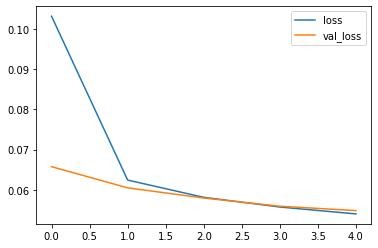

In [18]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# **Plotar gráfico da precisão**

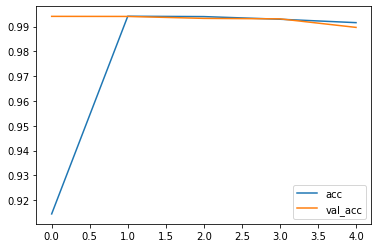

In [19]:
# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

# **Imprimir valor da métrica AUC**

In [20]:
# plot the mean AUC over each label
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))


0.9732938675537044


Primeiramente, realizamos uma previsão utilizando o modelo, e **utilizamos um loop para percorrer cada uma das camadas da rede neural construída**.

- No caso, são as colunas em "targets" e "predictions".
- Para cada coluna, calculamos a métrica AUC e, ao fim, tomamos o valor médio das 6 métricas obtidas.

Também **poderíamos ter dividido os dados em um conjunto de treino e um conjunto de teste**.

Note ainda que **os resultados do modelo RNN são superiores aos obtidos anteriormente com a CNN**.
- Isto é consequência do elevado desempenho mostrado pela LSTM para trabalho com sequências.

# **NOTA: Realizar previsões com o modelo**

Note que o comando `model.predict(X)` calcula os valores previstos pelo modelo `model` para cada um dos valores do dataframe `X` fornecido como input.